In [ ]:
# %%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
from tensorflow import keras
from keras import applications, optimizers, callbacks, Sequential, metrics
     
# !pip install -U --no-cache-dir gdown --pre
# !gdown --id 1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID
!gdown --id 1YVkLONpVU9eEsPbkBI7qfEXoSdMGVLMk
!unzip /content/wights_batel_adi

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YVkLONpVU9eEsPbkBI7qfEXoSdMGVLMk
To: /content/wights_batel_adi.zip
100% 636M/636M [00:17<00:00, 36.6MB/s]
Archive:  /content/wights_batel_adi.zip
  inflating: wights_batel_adi/base128.h5  
  inflating: wights_batel_adi/sec128.h5  
  inflating: wights_batel_adi/sec128_fineTun.h5  
  inflating: wights_batel_adi/model224.h5  


In [ ]:
!gdown --id 1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID
To: /content/labels_dic.csv
100% 6.14k/6.14k [00:00<00:00, 10.9MB/s]


In [ ]:
# This chunk works.
!pip uninstall --yes gdown # After running this line, restart Colab runtime.

!pip install gdown -U --no-cache-dir

import gdown

url = 'https://drive.google.com/uc?id=1YVkLONpVU9eEsPbkBI7qfEXoSdMGVLMk'

gdown.download_folder(url)

Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Retrieving folder list
Failed to retrieve folder contents:

 	Cannot retrieve the folder information from the link. You may need to
	change the permission to 'Anyone with the link'. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset
Cars196 - 196 different classes of vehicles

In [ ]:
%%capture
cars196 = tfds.load('Cars196', as_supervised=True, shuffle_files=True)

Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [ ]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

### Function - Plot Single Example
This function receives an image and a label and it will display it on a plot

In [ ]:
def plot_single_example(image, label, label_dic=label_dic):
  car_model_by_label = label_dic[str(label)]
  plt.title(f'Image Label: {car_model_by_label} ({label})')
  plt.imshow(image)
  


# Data Preprocessing

### Split Dataset
Train set contains 8041 examples<br>
Test set contains 8144 examples<br>
**It is allowed to change the ratio between the data sets.**


In [ ]:
cars_train=cars196['train']
cars_test=cars196['test']
# Concatenate the train set and test set
cars = cars_train.concatenate(cars_test)

# Calculate the number of examples in the train and test datasets
TRAIN_SIZE = int(0.9 * len(cars))
TEST_SIZE = int(len(cars) - TRAIN_SIZE)

# Create the train and test datasets
train_ds = cars.take(TRAIN_SIZE)
cars_test = cars.skip(TRAIN_SIZE)

# create validation dataset
VALIDATION_SIZE = int(0.2 * len(train_ds))
cars_val = train_ds.take(VALIDATION_SIZE)

# create train dataset
cars_train = train_ds.skip(VALIDATION_SIZE)



### Example
Random example from the data set

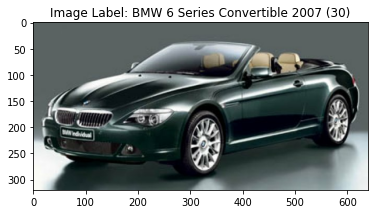

In [ ]:
image, label = cars_train.as_numpy_iterator().next()
plot_single_example(image, label)


In [ ]:
cars_tr=cars196['train']

In [ ]:
image, label = next(iter(cars_tr))

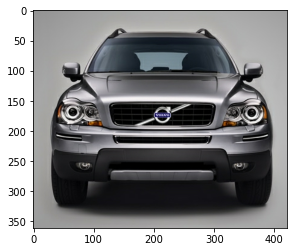

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [ ]:
def preprocess(image, label):
  image=tf.image.resize(image,[128,128])
  image= tf.cast(image, tf.float32)/255.0
  return image, label

In [ ]:
def aug(image, label):
  image = tf.image.random_crop(image, size=[128, 128,3])
  image=tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, 0.1)
  image = tf.image.random_hue(image, 0.25)
  image = tf.image.random_saturation(image, 0, 2)
  return image, label

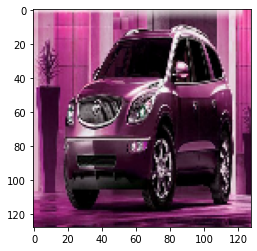

In [ ]:
for image,label in iter(cars_tr):
  image,label=preprocess(image,label)
  image, label=aug(image, label)
  plt.imshow(image)
  break

#Data set *construction*

In [ ]:
cars_train=cars_train.map(preprocess).map(aug).shuffle(800).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
cars_test=cars_test.map(preprocess).shuffle(800).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
cars_val=cars_val.map(preprocess).map(aug).shuffle(800).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
# cars_val = cars_train.take(int(0.2 * len(cars_train)))
# cars_train = cars_train.skip(int(0.2 * len(cars_train)))

#testing if the augmantation is working

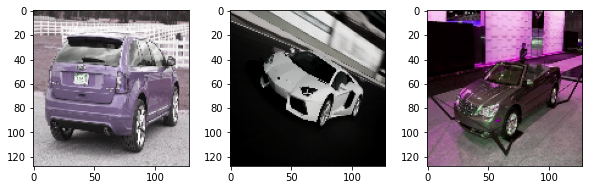

In [ ]:
plt.figure(figsize=(10,20))
for i,(image_batch,label) in enumerate(cars_val.take(3)):
    ax=plt.subplot(6, 3, i+1)
    plt.imshow(image_batch[0])

In [ ]:
def graphFunc(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.plot(history.history['sparse_categorical_accuracy'])
  plt.plot(history.history['val_sparse_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

#Base model, 128*128 image size, no fine tuning
image net weights.
no repeat on the dataset

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(196,activation='softmax')(x)
base128 = keras.Model(inputs, outputs)

In [ ]:
base128.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(),
              metrics=[metrics.SparseCategoricalAccuracy()])
callback = [
             callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True),
             callbacks.TerminateOnNaN()
            ]
thistory = base128.fit(cars_train, epochs=20, callbacks=callback, validation_data=cars_val)
base128.save('/content/drive/MyDrive/wights_batel_adi/base128.h5')


Epoch 1/20


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


183/183 [==============================] - 41s 176ms/step - loss: 4.9290 - sparse_categorical_accuracy: 0.0473 - val_loss: 4.2029 - val_sparse_categorical_accuracy: 0.1030
Epoch 2/20
183/183 [==============================] - 35s 160ms/step - loss: 4.0931 - sparse_categorical_accuracy: 0.1201 - val_loss: 4.0343 - val_sparse_categorical_accuracy: 0.1260
Epoch 3/20
183/183 [==============================] - 36s 164ms/step - loss: 3.8015 - sparse_categorical_accuracy: 0.1592 - val_loss: 3.9345 - val_sparse_categorical_accuracy: 0.1459
Epoch 4/20
183/183 [==============================] - 35s 161ms/step - loss: 3.5614 - sparse_categorical_accuracy: 0.1926 - val_loss: 3.8429 - val_sparse_categorical_accuracy: 0.1713
Epoch 5/20
183/183 [==============================] - 34s 157ms/step - loss: 3.4213 - sparse_categorical_accuracy: 0.2177 - val_loss: 3.8182 - val_sparse_categorical_accuracy: 0.1682
Epoch 6/20
183/183 [==============================] - 35s 160ms/step - loss: 3.2906 - sparse_cat

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,confusion_matrix

def eval(model,cars_t):
  # Use the Keras model's predict method to make predictions on the test data
  predictions = model.predict(cars_t)
  y_true = np.concatenate([y.numpy() for x, y in cars_t], axis=0)
  # Evaluate the predictions using the test labels
  test_loss, test_accuracy = model.evaluate(cars_t)
  y_pred = [tf.argmax(pred).numpy() for pred in predictions]
  # Compute the confusion matrix using the predicted and true labels
  cm = confusion_matrix(y_true, y_pred)
  ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
  print(classification_report(y_true,y_pred, labels=range(0,195)))
  plt.show()
  print('Test loss:', test_loss)
  print('Test accuracy:', test_accuracy)

Test and evaluation

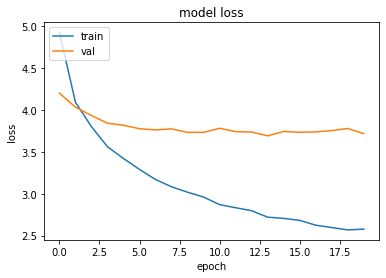

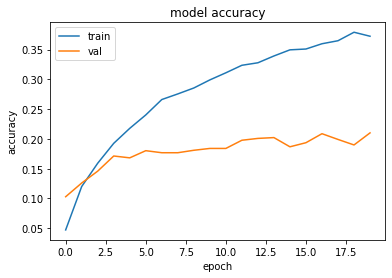

26/26 [==============================] - 27s 83ms/step - loss: 3.7081 - sparse_categorical_accuracy: 0.1927


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.08      0.08      0.08        12
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         9
          10       0.05      0.14      0.07         7
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00        10
          17       0.00    

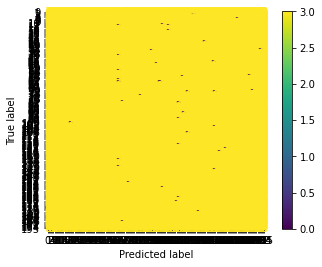

Test loss: 3.7081058025360107
Test accuracy: 0.19271154701709747


In [ ]:
# cars_test=cars196['test']
graphFunc(thistory)
model = keras.models.load_model('/content/drive/MyDrive/wights_batel_adi/base128.h5')
eval(model, cars_test)

#Second model 128*128 with fine tunning.
same arcittecture, double the data set.

In [ ]:
# cars_test=cars196['test']
# cars_train=cars196['train']
car = cars_train.concatenate(cars_test)
TRAIN_SIZE = int(0.9 * len(cars))
train_ds = cars.take(TRAIN_SIZE)
VALIDATION_SIZE = int(0.2 * len(train_ds))
cars_val = train_ds.take(VALIDATION_SIZE)
# create train dataset
cars_train = train_ds.skip(VALIDATION_SIZE)
ds = cars_train.repeat(2)

In [ ]:
ds=cars_train.repeat(2)
cars_train=ds.map(preprocess).map(aug).shuffle(800).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
cars_val = cars_train.take(int(0.2 * len(cars_train)))
cars_train = cars_train.skip(int(0.2 * len(cars_train)))

The model

In [ ]:
sec_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
sec_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = sec_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(196,activation='softmax')(x)
sec128 = keras.Model(inputs, outputs)

In [ ]:
sec128.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(),
              metrics=[metrics.SparseCategoricalAccuracy()])
callback = [
             callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True),
             callbacks.TerminateOnNaN()
            ]
history = sec128.fit(cars_train, epochs=10, callbacks=callback, validation_data=cars_val)
sec128.save('path/to/sec128.h5')
sec128.save('/content/drive/MyDrive/wights_batel_adi/sec128.h5')

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


292/292 [==============================] - 79s 216ms/step - loss: 4.6226 - sparse_categorical_accuracy: 0.0746 - val_loss: 3.7538 - val_sparse_categorical_accuracy: 0.1762
Epoch 2/10
292/292 [==============================] - 76s 212ms/step - loss: 3.7639 - sparse_categorical_accuracy: 0.1697 - val_loss: 3.3600 - val_sparse_categorical_accuracy: 0.2391
Epoch 3/10
292/292 [==============================] - 70s 190ms/step - loss: 3.4468 - sparse_categorical_accuracy: 0.2148 - val_loss: 3.1284 - val_sparse_categorical_accuracy: 0.2812
Epoch 4/10
292/292 [==============================] - 75s 211ms/step - loss: 3.2173 - sparse_categorical_accuracy: 0.2583 - val_loss: 2.9968 - val_sparse_categorical_accuracy: 0.3084
Epoch 5/10
292/292 [==============================] - 69s 190ms/step - loss: 3.0534 - sparse_categorical_accuracy: 0.2887 - val_loss: 2.8448 - val_sparse_categorical_accuracy: 0.3290
Epoch 6/10
292/292 [==============================] - 70s 192ms/step - loss: 2.9179 - sparse_cat

#Fine-tuning
Once the model has converged on the new data, we can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

In [ ]:
sec_model.trainable = True
sec128.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[metrics.SparseCategoricalAccuracy()])
callback = [
             callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True),
             callbacks.TerminateOnNaN()
            ]
tun_history=sec128.fit(cars_train, epochs=10, callbacks=callback, validation_data=cars_val)
# sec128.save('path/to/sec128_fineTun.h5')
sec128.save('/content/drive/MyDrive/wights_batel_adi/sec128_fineTun.h5')

Epoch 1/10
292/292 [==============================] - 157s 413ms/step - loss: 2.0751 - sparse_categorical_accuracy: 0.4803 - val_loss: 1.8090 - val_sparse_categorical_accuracy: 0.5460
Epoch 2/10
292/292 [==============================] - 127s 387ms/step - loss: 1.7482 - sparse_categorical_accuracy: 0.5494 - val_loss: 1.5865 - val_sparse_categorical_accuracy: 0.5940
Epoch 3/10
292/292 [==============================] - 133s 407ms/step - loss: 1.5568 - sparse_categorical_accuracy: 0.5924 - val_loss: 1.4399 - val_sparse_categorical_accuracy: 0.6299
Epoch 4/10
292/292 [==============================] - 127s 387ms/step - loss: 1.4046 - sparse_categorical_accuracy: 0.6244 - val_loss: 1.3173 - val_sparse_categorical_accuracy: 0.6597
Epoch 5/10
292/292 [==============================] - 133s 407ms/step - loss: 1.2739 - sparse_categorical_accuracy: 0.6489 - val_loss: 1.1829 - val_sparse_categorical_accuracy: 0.6813
Epoch 6/10
292/292 [==============================] - 127s 388ms/step - loss: 1.

Test and evaluation

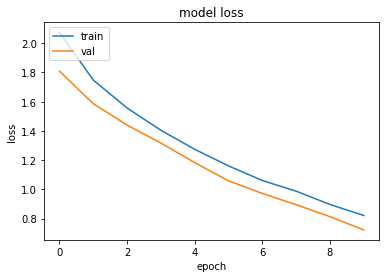

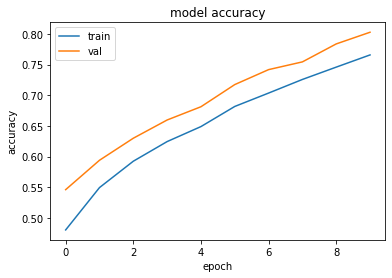

26/26 [==============================] - 27s 84ms/step - loss: 3.0187 - sparse_categorical_accuracy: 0.3904
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00        13
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         9
          15       0.00    

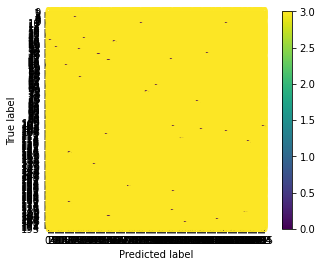

Test loss: 3.0186638832092285
Test accuracy: 0.390364408493042


In [ ]:
# cars_test=cars196['test']
graphFunc(tun_history)
model = keras.models.load_model('/content/drive/MyDrive/wights_batel_adi/sec128_fineTun.h5')
eval(model, cars_test)

#third experiment, 
changing the images sizes to 224, double the data set and fine tuning.

In [ ]:
def preprocess(image, label):
  image=tf.image.resize(image,[224,224])
  image= tf.cast(image, tf.float32)/255.0
  return image, label

In [ ]:
def aug(image, label):
  image = tf.image.random_crop(image, size=[224, 224,3])
  image=tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, 0.1)
  image = tf.image.random_hue(image, 0.25)
  image = tf.image.random_saturation(image, 0, 2)
  return image, label

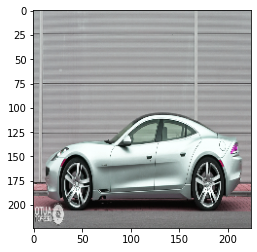

In [ ]:
for image,label in iter(cars_tr):
  image,label=preprocess(image,label)
  image,label=aug(image,label)
  plt.imshow(image)
  break


In [ ]:
cars_train=cars196['train']
cars_test=cars196['test']

cars = cars_train.concatenate(cars_test)

TRAIN_SIZE = int(0.9 * len(cars))
TEST_SIZE = int(len(cars) - TRAIN_SIZE)

train_ds = cars.take(TRAIN_SIZE)
cars_test = cars.skip(TRAIN_SIZE)
ds = train_ds.repeat(2)


VALIDATION_SIZE = int(0.2 * len(ds))
cars_val = ds.take(VALIDATION_SIZE)

cars_train = ds.skip(VALIDATION_SIZE)

In [ ]:
cars_train=cars_train.map(preprocess).map(aug).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
cars_test=cars_test.map(preprocess).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
cars_val=cars_val.map(preprocess).map(aug).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
# cars_val = cars_train.take(int(0.2 * len(cars_train)))

# cars_train = cars_train.skip(int(0.2 * len(cars_train)))

In [ ]:
# plt.figure(figsize=(10,20))
# for i,(image_batch,label) in enumerate(cars_train.take(6)):
#     ax=plt.subplot(6, 3, i+1)
#     plt.imshow(image_batch[0])

#The final model

In [ ]:
model224_base = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
model224_base.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = model224_base(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(196,activation='softmax')(x)
model224 = keras.Model(inputs, outputs)

In [ ]:
model224.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=optimizers.Adam(),
              metrics=[metrics.SparseCategoricalAccuracy()])
callback = [
             callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True),
             callbacks.TerminateOnNaN()
            ]
model224.fit(cars_train, epochs=10, callbacks=callback, validation_data=cars_val)
model224.save('/content/drive/MyDrive/wights_batel_adi/model.h5')

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


729/729 [==============================] - 139s 159ms/step - loss: 3.7522 - sparse_categorical_accuracy: 0.1586 - val_loss: 2.9771 - val_sparse_categorical_accuracy: 0.2985
Epoch 2/10
729/729 [==============================] - 127s 160ms/step - loss: 2.8593 - sparse_categorical_accuracy: 0.3044 - val_loss: 2.5821 - val_sparse_categorical_accuracy: 0.3697
Epoch 3/10
729/729 [==============================] - 128s 161ms/step - loss: 2.5280 - sparse_categorical_accuracy: 0.3738 - val_loss: 2.3247 - val_sparse_categorical_accuracy: 0.4274
Epoch 4/10
729/729 [==============================] - 128s 162ms/step - loss: 2.3309 - sparse_categorical_accuracy: 0.4130 - val_loss: 2.1688 - val_sparse_categorical_accuracy: 0.4574
Epoch 5/10
729/729 [==============================] - 129s 162ms/step - loss: 2.1689 - sparse_categorical_accuracy: 0.4431 - val_loss: 2.0458 - val_sparse_categorical_accuracy: 0.4825
Epoch 6/10
729/729 [==============================] - 129s 162ms/step - loss: 2.0721 - spar

#Fine tuning

In [ ]:
model224_base.trainable = True
model224.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[metrics.SparseCategoricalAccuracy()])
callback = [
             callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True),
             callbacks.TerminateOnNaN()
            ]
history = model224.fit(cars_train, epochs=10, callbacks=callback, validation_data=cars_val)
model224.save('path/to/model224.h5')
# Train end-to-end. Be careful to stop before you overfit!

Epoch 1/10
729/729 [==============================] - 409s 510ms/step - loss: 1.1575 - sparse_categorical_accuracy: 0.6765 - val_loss: 0.8506 - val_sparse_categorical_accuracy: 0.7697
Epoch 2/10
729/729 [==============================] - 384s 513ms/step - loss: 0.8153 - sparse_categorical_accuracy: 0.7621 - val_loss: 0.6235 - val_sparse_categorical_accuracy: 0.8258
Epoch 3/10
729/729 [==============================] - 384s 513ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.8132 - val_loss: 0.5041 - val_sparse_categorical_accuracy: 0.8577
Epoch 4/10
729/729 [==============================] - 384s 512ms/step - loss: 0.5216 - sparse_categorical_accuracy: 0.8423 - val_loss: 0.3963 - val_sparse_categorical_accuracy: 0.8913
Epoch 5/10
729/729 [==============================] - 384s 513ms/step - loss: 0.4235 - sparse_categorical_accuracy: 0.8706 - val_loss: 0.3184 - val_sparse_categorical_accuracy: 0.9101
Epoch 6/10
729/729 [==============================] - 384s 512ms/step - loss: 0.

In [ ]:
def preprocess(image, label):
  image=tf.image.resize(image,[224,224])
  image= tf.cast(image, tf.float32)/255.0
  return image, label

In [ ]:
model224.save('/content/drive/MyDrive/wights_batel_adi/model224.h5')

Test and evaluation

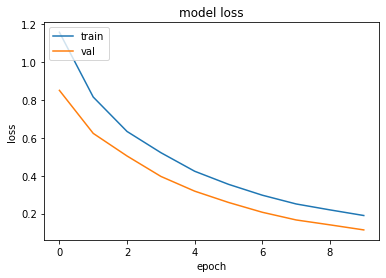

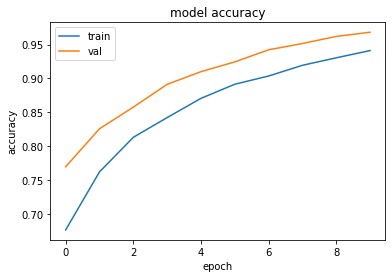

252/252 [==============================] - 36s 130ms/step


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


252/252 [==============================] - 37s 134ms/step - loss: 0.2469 - sparse_categorical_accuracy: 0.9445
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        44
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00        42
           4       0.00      0.00      0.00        40
           5       0.02      0.02      0.02        44
           6       0.03      0.03      0.03        39
           7       0.02      0.02      0.02        45
           8       0.03      0.02      0.02        41
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        38
          11       0.00      0.00      0.00        36
          12       0.00      0.00      0.00        41
          13       0.00      0.00      0.00        42
          14       0.00      0.00      0.00        43
          15       0.02 

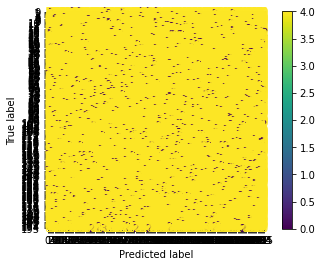

Test loss: 0.24688799679279327
Test accuracy: 0.9445342421531677


In [ ]:
graphFunc(history)
cars_test=cars196['test']
cars_test=cars_test.map(preprocess).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
model = keras.models.load_model('/content/drive/MyDrive/wights_batel_adi/model224.h5')
eval(model, cars_test)

#KNN ON TRANSFER BEST MODEL

First experimant 

In [ ]:
cars_test = cars196['test']
model = keras.models.load_model('/content/drive/MyDrive/wights_batel_adi/model224.h5')
fc_model = keras.Model(inputs=model.input, outputs=model.get_layer("flatten").output)
cars_t=cars_test.map(preprocess).shuffle(800).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Assigns predicted label id's for the image_batch to variables
vectors = fc_model.predict(cars_t) 


252/252 [==============================] - 34s 128ms/step


In [ ]:
#checking we got a vector for every image
print(len(cars_test))
print(vectors.shape)

8041
(8041, 2048)


In [ ]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors()
nei_clf.fit(vectors)


NearestNeighbors()

In [ ]:
def get_similar(image, n_neighbors=5):
    # print(test_image_as_batch.shape)
    # test_image_as_batch = np.expand_dims(image, axis = 0)
    print("original image shape:")
    print(image.shape)
    image = image.reshape(1,224,224,3)
    vect = fc_model.predict(image) 
    print("image vectors shape:")
    print(vect.shape)
    #print(image.shape)
    #assert image.ndim==3,"image must be [batch,height,width,3]"
    (distances),(idx) = nei_clf.kneighbors(vect,n_neighbors=n_neighbors)
    print("distances in get_similar:")
    print(distances)
    print("idx in get_similar:")
    print(idx)
    plt.scatter(vectors[:,0], vectors[:,1], color='blue')
    plt.scatter(vectors[idx,0], vectors[idx,1], color='red', marker='x')
    plt.show()
    return distances, idx

In [ ]:
def show_similar(image,label,neighbors=3):
    distances,idx = get_similar(image,n_neighbors=neighbors)
    plt.figure(figsize=[15,10])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Original image")
    print("original image class:")
    print(label)
    label = label_dic.get(str(label))
    print(f"Original image label:")
    print(label)
    
    data_enu = cars_t.unbatch().enumerate()
    for i in range(neighbors):
      # print(type(list(data_enu.as_numpy_iterator())[0]))
      nei = data_enu.filter(lambda x,y:x==idx[0][i])
      # print(nei.as_numpy_iterator().next())
      nei_img = nei.as_numpy_iterator().next()[1][0]
      nei_lbl = nei.as_numpy_iterator().next()[1][1]
      print(f"neighbor {i} idx:")
      print(nei.as_numpy_iterator().next()[0])
      print(f"neighbor {i} class:")
      print(nei_lbl)
      # nei_pred = t128_model.predict(nei_img)
      # result_id = np.argmax(nei_pred)
      # print(nei_pred.shape)
      label = label_dic.get(str(nei_lbl))
      print(f"neighbor {i} label:")
      print(label)
      plt.subplot(1,4,i+2)
      plt.imshow(nei_img)
      plt.title(f"Dist={distances[0][i]}")
    plt.show()


original image shape:
(224, 224, 3)
1/1 [==============================] - 0s 24ms/step
image vectors shape:
(1, 2048)
distances in get_similar:
[[2.31401168e-05 1.35650711e+01 1.48561107e+01]]
idx in get_similar:
[[ 196 3083 7289]]


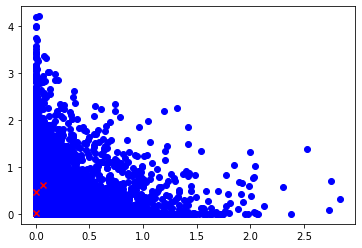

original image class:
10
Original image label:
Aston Martin Virage Coupe 2012
neighbor 0 idx:
196
neighbor 0 class:
47
neighbor 0 label:
Buick Rainier SUV 2007
neighbor 1 idx:
3083
neighbor 1 class:
61
neighbor 1 label:
Chevrolet Tahoe Hybrid SUV 2012
neighbor 2 idx:
7289
neighbor 2 class:
119
neighbor 2 label:
GMC Yukon Hybrid SUV 2012


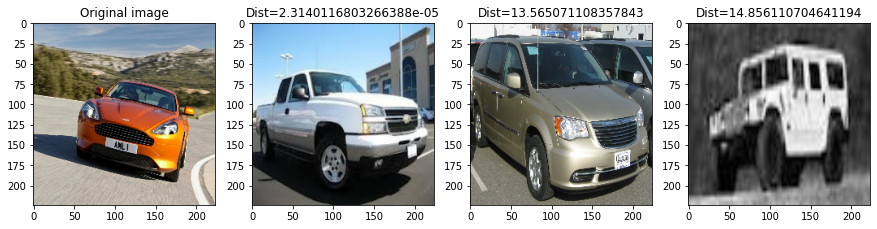

In [ ]:
image, label = cars_t.unbatch().as_numpy_iterator().next()

show_similar(image, label, neighbors=3)

#Second experimant 
changing the algorithm distance metric

In [ ]:
nei_clf = NearestNeighbors(metric="sqeuclidean")
nei_clf.fit(vectors)

NearestNeighbors(metric='sqeuclidean')

original image shape:
(224, 224, 3)
1/1 [==============================] - 0s 24ms/step
image vectors shape:
(1, 2048)
distances in get_similar:
[[5.35465006e-10 1.84011157e+02 2.20704023e+02]]
idx in get_similar:
[[ 196 3083 7289]]


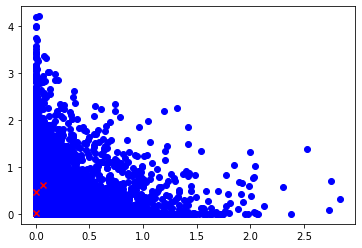

original image class:
10
Original image label:
Aston Martin Virage Coupe 2012
neighbor 0 idx:
196
neighbor 0 class:
181
neighbor 0 label:
Suzuki Kizashi Sedan 2012
neighbor 1 idx:
3083
neighbor 1 class:
27
neighbor 1 label:
BMW 1 Series Coupe 2012
neighbor 2 idx:
7289
neighbor 2 class:
117
neighbor 2 label:
GMC Terrain SUV 2012


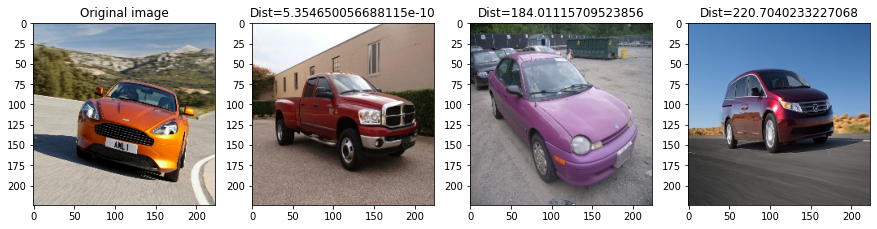

In [ ]:
show_similar(image, label, neighbors=3)

In [ ]:
batch = cars_t.as_numpy_iterator().next()
images=batch[0]
labels=batch[1]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
vectors_to_class = fc_model.predict(images) 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(vectors_to_class, labels)
image= np.reshape(image, (1,224,224,3))
print(image.shape)
image_vec = fc_model.predict(image) 
print(neigh.predict(image_vec))
print(f'real label: {label}')
print(neigh.predict_proba(image_vec))
score = neigh.score(vectors_to_class,labels)
print(f'the accuracy score is: {score}')

1/1 [==============================] - 0s 41ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
[24]
real label: 10
[[0.         0.         0.         0.         0.         0.
  0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.33333333 0.         0.         0.
  0.         0.         0.         0.33333333 0.         0.
  0.         0.         0.         0.         0.        ]]
the accuracy score is: 0.4375


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
vectors_to_class = fc_model.predict(images) 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(vectors_to_class, labels)
image= np.reshape(image, (1,224,224,3))
print(image.shape)
image_vec = fc_model.predict(image) 
print(neigh.predict(image_vec))
print(f'real label: {label}')
print(neigh.predict_proba(image_vec))
score = neigh.score(vectors_to_class,labels)
print(f'the accuracy score is: {score}')

1/1 [==============================] - 0s 31ms/step
(1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
[24]
real label: 10
[[0.         0.         0.         0.         0.         0.
  0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.33333333 0.         0.         0.
  0.         0.         0.         0.33333333 0.         0.
  0.         0.         0.         0.         0.        ]]
the accuracy score is: 0.4375


In [ ]:
from google.colab import files
from IPython.display import Image

# Test on best models
upload your on image and write the path in load so u can test it yourself

In [ ]:
uploaded = files.upload()

Saving download.jpeg to download.jpeg


#the third transfer learning model test yourself

In [ ]:
import numpy as np
from keras.preprocessing import image
#add the path in the load image 
test_image = tf.keras.utils.load_img('/content/download.jpeg', target_size = (224, 224,3))
image=tf.image.resize(test_image,[224,224])
image= tf.cast(test_image, tf.float32)/255.0
model = keras.models.load_model('/content/wights_batel_adi/model224.h5')
test_image_as_batch = np.expand_dims(image, axis = 0)
result = model.predict(test_image_as_batch)
class_id = np.argmax(result)



1/1 [==============================] - 9s 9s/step


Infiniti QX56 SUV 2011
141


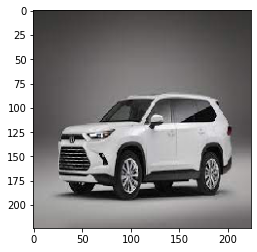

In [ ]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()
print(label_dic[str(class_id)])
print(class_id)
plt.imshow(image)

#The best image retrival model test yourself
with the same image you uploaded

In [ ]:
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
model = keras.models.load_model('/content/wights_batel_adi/model224.h5')
fc_model = keras.Model(inputs=model.input, outputs=model.get_layer("flatten").output)




In [ ]:
batch = cars_t.as_numpy_iterator().next()
images=batch[0]
labels=batch[1]

In [ ]:
def get_single_prediction(image):
  plt.imshow(image[0])
  print("b4 predict")
  image_vec = fc_model.predict(image) 
  result = neigh.predict(image_vec)
  print(result[0])
  maxIndex = result[0]
  label = label_dic.get(str(maxIndex))
  print(f'label {maxIndex}: {label}')


In [ ]:
from keras.preprocessing import image
test_image = tf.keras.utils.load_img('/content/download.jpeg', target_size = (224, 224))
test_image_as_batch = np.expand_dims(test_image, axis = 0)


In [ ]:
get_single_prediction(test_image_as_batch)